# Prática de Cache em Matrizes

## Introdução

A multiplicação de matrizes é uma das principais operações em diversos métodos numéricos, dessa forma, é interessante que sejam implementadas técnicas de otimização para que em certos casos o tempo de execução de operações baseadas na multiplicação de matrizes seja cada vez menor.

Na literatura da área, existem diversos algoritmos para a multiplicação de matrizes, como o _divide and conqueer_ e algoritmos paralelos e/ou distribuídos. Nesse relatório será estudado o algoritmo Iterativo.

### Algoritmo Iterativo

Pela definição matemática, seja uma matrix $C = AB$, onde $A$ tem dimensões $n x m$ e B tem dimensões $m x p$, assim, a matrix $C$ terá dimensões $n x p$ e suas entradas serão: 

$c_{ij} =  \sum_{i=1}^{m} a_{ik}b_{kj}$

Portanto, um algoritmo simples iterativo com complexidade de $\mathcal{O}(nmp)$ pode ser construído. O exemplo a seguir ilustra isso:

In [4]:
a = [[1,2,3], [4,5,6]]
b = [[7,8], [9,10], [11,12]]

def matrix_multiply(a, b):
    n,m,p = len(a), len(a[0]), len(b[0])
    c = [[0 for i in range(p)] for j in range(n)]
    for i in range(n):
        for j in range(p):
            for k in range(m):
                c[i][j] += a[i][k] * b[k][j]
    return c

print(matrix_multiply(a, b))



[[58, 64], [139, 154]]


#### Memória Cache

A ordem de acesso aos elementos das matrizes é irrelevante para o funcionamento do algoritmo ou sua complexidade assintótica, porém, essa ordem pode ter um impacto considerável de performance levando em consideração os padrões de acesso a memória e uso de memória cache do algoritmo.

## Objetivos

Levando em consideração a implementação clássica do algoritmo de multiplicação de matrizes e uma implementação paralela, utilizando a segunda matriz transposta e acessando as suas colunas em forma de linha, esse relatório tem como objetivo comparar métricas de tempo de execução e de acesso à memória cache entre esses dois algoritmos. 

## Materiais e Métodos

### Implementações 

Para a implementação de todos os algoritmos, testes e benchmarks foi utilizada a linguagem de programação [c++](https://www.cplusplus.com/) e o build system [cmake](https://cmake.org). A utilização do _c++_ se justifica pela sua natureza compilada e performática, que como a linguagem _c_ produz executáveis muito rápidos e permite a utilização de programação orientada a objetos. Já o _cmake_ foi escolhido pois facilita os processos de compilação e execução de projetos feitos em _c++_. 

### Testes

Para a validação de ambos os algoritmos implementados, foi utilizado testes unitários e a biblioteca de testes para linguagem _c++_ [googletest](https://google.github.io/googletest/).

Os testes foram realizados em duas classes de matrizes, as matrizes pequenas, onde tanto as matrizes quanto os resultados foram inseridas no código e mas matrizes grandes (2000x2000), onde o resultado foi calculado em uma ferramenta externa e testado.

Para cada classe de matriz foi realizado testes de multiplicação entre matrizes quadradas e não quadradas.

### Benchmarks

#### Tempo

Os benchmarks de tempo foram utilizados a biblioteca [googlebenchmark](https://github.com/google/benchmark/blob/main/docs/user_guide.md). Para cada tamanho de matriz quadrada, foram realizadas 10 execuções, e extraídos dados estatísticos como média de tempo e desvio padrão das execuções.

Os tamanhos de matrizes testados foram de: 

In [5]:
list(range(200, 2000, 200))

[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800]

#### Memória Cache

Os benchmarks relativos a utilização de memória cache foram feitos utilizando a ferramenta [valgrind](https://valgrind.org/), mais especificamente a sub-ferramenta _cachegrind_.

## Resultados e Discussão

### Compilação do projeto

O projeto utiliza o _cmake_ como ferramenta de compilação, então, para construir o projeto, é necessário que o usuário tenha o **cmake** e o **ninja** instalado.

Assim, para configurar o projeto e baixar as dependências necessárias:

In [ ]:
!/usr/bin/cmake \
  -DCMAKE_INSTALL_MESSAGE=NEVER\
  -DCMAKE_MESSAGE_LOG_LEVEL=WARNING\
  -DCMAKE_EXPORT_COMPILE_COMMANDS:BOOL=TRUE\
  -DCMAKE_BUILD_TYPE:STRING=Release\
  -DCMAKE_C_COMPILER:FILEPATH=/usr/bin/clang\
  -DCMAKE_CXX_COMPILER:FILEPATH=/usr/bin/clang++\
  -S/mnt/files/projects/Unioeste/matrix_cache\
  -B/mnt/files/projects/Unioeste/matrix_cache/build\
  -G Ninja

Depois, para buildar os binários do projeto:

In [ ]:
!/usr/bin/cmake \
  --build /mnt/files/projects/Unioeste/matrix_cache/build\
  --config Release\
  --target all

Por fim, para mover os binários para a pasta `./dist/bin`, basta executar o comando:

In [ ]:
!/usr/bin/cmake\
  --build /mnt/files/projects/Unioeste/matrix_cache/build\
  --config Release\
  --target install\

In [ ]:
!ls dist/bin

Os binários `matrix_cache_benchmarks` e `matrix_cache_tests` são respectivamente os benchmarks e testes do projeto. Já o binário `matrix_cache_run` é um programa que realiza a multiplicação entre duas matrizes de tamanhos passados como argumentos.

### Implementações

#### Classe Matrix

A classe _Matrix_ utiliza o tipo de dados `**double` (ponteiros para arrays de doubles) e possui as operações básicas de: **igualdade**, **desigualdade**, **multiplicação**, **transposição** e **multiplicação com transposta**. A sua interface pode ser vista a seguir:

```cpp
class Matrix {
 private:
  double **matrix;
  int _rows, _cols;
  void alloc_mem();

 public:
  // constructors
  Matrix(int, int);
  Matrix(double **, int, int);
  Matrix(const Matrix &);
  Matrix();
  ~Matrix();

  // simple operations and operators
  inline double &operator()(int x, int y) { return matrix[x][y]; }
  Matrix &operator=(const Matrix &);
  Matrix &operator/=(double);
  Matrix &operator*=(const Matrix &);
  Matrix &operator*(const Matrix &);
  Matrix &operator^=(const Matrix &);
  Matrix &operator^(const Matrix &);
  bool operator==(const Matrix &);
  bool operator!=(const Matrix &);

  // transposition
  void swap_rows(int, int);
  Matrix transpose();

  // randomization
  Matrix &randomize(double, double);

  // matrix io
  friend std::ostream &operator<<(std::ostream &, const Matrix &);
  friend std::istream &operator>>(std::istream &, Matrix &);
};
```

#### Operação de Alocação

Foi utilizado o tipo de dados `**double` para armazenar a matriz. Assim, é armazenado um ponteiro para cada linha da matriz, e esse ponteiro aponta para um array de doubles. O método de alocação é mostrado a seguir: 

```cpp
void Matrix::alloc_mem() {
  matrix = new double *[_rows];
  for (int i = 0; i < _rows; i++) {
    matrix[i] = new double[_cols];
  }
}
```

#### Operação de Randomização


A Matriz é alocada com suas células setadas em 0. Porém, é disponibilizado um método de randomização das células da matriz. Assim, para cada entrada é atribuído um valor aleatório em um intervalo pré definido:

```cpp
Matrix::Matrix(int rows, int cols) : _rows(rows), _cols(cols) {
  alloc_mem();
  for (int i = 0; i < rows; i++) {
    fill(matrix[i], matrix[i] + cols, 0);
  }
}
```

```cpp
Matrix &Matrix::randomize(double min = 0, double max = 1) {
  RandomNumberBetween rnb(min, max);

  for (int i = 0; i < _rows; i++) {
    generate(matrix[i], matrix[i] + _cols, rnb);
  }

  return *this;
}
```


A classe `RandomNumberBetween` utiliza features modernas do _c++_ para gerar números aleatórios de maneira confiável:

```cpp
class RandomNumberBetween {
 public:
  RandomNumberBetween(double low, double high);
  double operator()();

 private:
  mt19937 random_engine_;
  uniform_real_distribution<double> distribution_;
};

RandomNumberBetween::RandomNumberBetween(double low, double high)
    : random_engine_(random_device()()), distribution_(low, high) {}

double RandomNumberBetween::operator()() {
  return distribution_(random_engine_);
}
```

#### Operação de igualdade 

O operador de igualdade entre matrizes foi construído com base em uma função de comparação que leva em consideração um pequena diferença entre os _doubles_ comparados. Isso ajuda a evitar problemas relacionados a comparação de igualdade estrita entre números de ponto flutuante. A função é mostrada a seguir: 

```cpp
bool absolute_tolerance_compare(double x, double y) {
  const double diff = fabs(x - y);
  // const double epsilon = numeric_limits<double>::epsilon();
  constexpr double epsilon = 1e-6;
  const bool result = diff <= epsilon;
  return result;
}
```

#### Operação de Transposição

A operação de transposição foi implementada da seguinte forma:

```cpp
Matrix Matrix::transpose() {
  Matrix temp_matrix(_cols, _rows);
  for (int i = 0; i < _rows; i++) {
    for (int j = 0; j < _cols; j++) {
      temp_matrix.matrix[j][i] = matrix[i][j];
    }
  }
  return temp_matrix;
}
```

#### Operação de Multiplicação

A operação clássica de multiplicação de matrizes iterativa foi implementada dessa forma:

```cpp
Matrix &Matrix::operator*(const Matrix &other) {
  if (_cols != other._rows) {
    throw domain_error("Matrices must have the same dimensions");
  }

  Matrix *temp_matrix = new Matrix(_rows, other._cols);

  for (int i = 0; i < _rows; i++) {
    for (int j = 0; j < other._cols; j++) {
      for (int k = 0; k < _cols; k++) {
        temp_matrix->matrix[i][j] += matrix[i][k] * other.matrix[k][j];
      }
    }
  }

  return *temp_matrix;
}
```

Note a maneira de acesso aos elementos da segunda matriz: `k` itera pelas linhas da matriz para obter os elementos de uma coluna específica.

#### Operação de Multiplicação Transposta

A operação de multiplicação com a segunda matriz transposta e com acesso por linhas foi implementada desse modo: 

```cpp
Matrix &Matrix::operator^(const Matrix &other) {
  if (_cols != other._cols) {
    throw domain_error("Matrices must have the same dimensions");
  }

  Matrix *temp_matrix = new Matrix(_rows, other._rows);

  for (int i = 0; i < _rows; i++) {
    for (int j = 0; j < other._rows; j++) {
      for (int k = 0; k < _cols; k++) {
        temp_matrix->matrix[i][j] += matrix[i][k] * other.matrix[j][k];
      }
    }
  }

  return *temp_matrix;
}
```

Note a diferença na maneira de acesso em relação ao algoritmo anterior: dessa forma `k` itera pela linha atual da segunda matriz a fim de obter os valores das colunas, pois o método espera a segunda matriz transposta.

### Testes

Como discutido anteriormente, para validar ambos os algoritmos de multiplicação foi utilizado testes unitários. Os testes podem ser executados usando:

In [6]:
!cd dist/bin && ./matrix_cache_tests

[==========] Running 12 tests from 2 test suites.
[----------] Global test environment set-up.
[----------] 8 tests from MatrixSmallTest
[ RUN      ] MatrixSmallTest.testSquareMultiplicationEqual
[       OK ] MatrixSmallTest.testSquareMultiplicationEqual (0 ms)
[ RUN      ] MatrixSmallTest.testNonSquareMultiplicationEqual
[       OK ] MatrixSmallTest.testNonSquareMultiplicationEqual (0 ms)
[ RUN      ] MatrixSmallTest.testSquareMultiplicationNotEqual
[       OK ] MatrixSmallTest.testSquareMultiplicationNotEqual (0 ms)
[ RUN      ] MatrixSmallTest.testNonSquareMultiplicationNotEqual
[       OK ] MatrixSmallTest.testNonSquareMultiplicationNotEqual (0 ms)
[ RUN      ] MatrixSmallTest.testSquareMultiplicationTransposedEqual
[       OK ] MatrixSmallTest.testSquareMultiplicationTransposedEqual (0 ms)
[ RUN      ] MatrixSmallTest.testNonSquareMultiplicationTransposedEqual
[       OK ] MatrixSmallTest.testNonSquareMultiplicationTransposedEqual (0 ms)
[ RUN      ] MatrixSmallTest.testSquareMult

### Benchmarks

As configurações do ambiente, como Número de cores e cache. são mostrados a seguir:

In [7]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         43 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  8
  On-line CPU(s) list:   0-7
Vendor ID:               AuthenticAMD
  Model name:            AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx
    CPU family:          23
    Model:               24
    Thread(s) per core:  2
    Core(s) per socket:  4
    Socket(s):           1
    Stepping:            1
    Frequency boost:     enabled
    CPU(s) scaling MHz:  107%
    CPU max MHz:         2100.0000
    CPU min MHz:         1400.0000
    BogoMIPS:            4193.67
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall n
                         x mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_go
                         od nopl nonstop_tsc cpuid extd_apicid aperfmperf rapl p
           

Informações específicas sobre as memórias cache do ambiente:

In [8]:
!lscpu --cache

NAME ONE-SIZE ALL-SIZE WAYS TYPE        LEVEL SETS PHY-LINE COHERENCY-SIZE
L1d       32K     128K    8 Data            1   64        1             64
L1i       64K     256K    4 Instruction     1  256        1             64
L2       512K       2M    8 Unified         2 1024        1             64
L3         4M       4M   16 Unified         3 4096        1             64


#### Tempo

Algumas funções para facilitar a manipulação e visualização dos dados:

In [9]:
from tools import parse_bench_dict
from tools import parse_bench_json
from tools import plot_all_aggregations
from tools import plot_comparsion
from tools import plot_speedup
from tools import draw_table_comparsion
from tools import draw_speedup_table
from tools import draw_table
from tools import plot_data

##### Alocação

Os tempos de alocação de cada tamanho de matriz são mostrados a seguir:

In [10]:
!./dist/bin/matrix_cache_benchmarks \
  --benchmark_repetitions=10\
  --benchmark_report_aggregates_only=true\
  --benchmark_display_aggregates_only=true\
  --benchmark_out_format=json\
  --benchmark_out=dist/benchmarks_constructor.json\
  --benchmark_filter="BM_Matrix_Constructor"

O gráfico mostrando a **média**, **mediana**, **desvio padrão**, **máximo** e **mínimo** de tempo de alocação em função do tamanho da matriz pode ser visto a seguir:

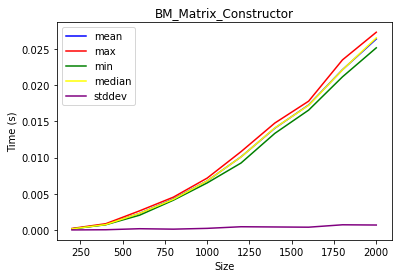

In [11]:
plot_all_aggregations(parse_bench_dict(parse_bench_json("./dist/benchmarks_constructor.json")), "BM_Matrix_Constructor")


Os mesmos dados organizados em uma tabela por tamanho da matriz:

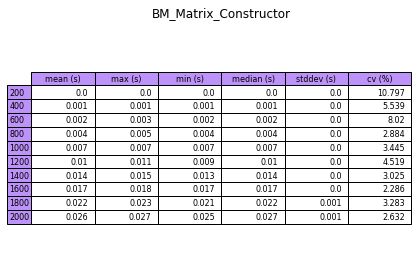

In [2]:
draw_table(parse_bench_dict(parse_bench_json("./dist/benchmarks_constructor.json")), "BM_Matrix_Constructor")

##### Randomização

Os tempos de randomização de cada tamanho de matriz são mostrados a seguir:

In [ ]:
!./dist/bin/matrix_cache_benchmarks \
  --benchmark_repetitions=10\
  --benchmark_report_aggregates_only=true\
  --benchmark_display_aggregates_only=true\
  --benchmark_out_format=json\
  --benchmark_out=dist/benchmarks_randomization.json\
  --benchmark_filter="BM_Matrix_Randomization"

O gráfico mostrando a **média**, **mediana**, **desvio padrão**, **máximo** e **mínimo** de tempo de randomização em função do tamanho da matriz pode ser visto a seguir:

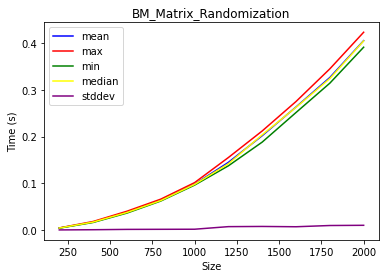

In [12]:
plot_all_aggregations(parse_bench_dict(parse_bench_json("./dist/benchmarks_randomization.json")), "BM_Matrix_Randomization")

Os mesmos dados organizados em uma tabela por tamanho da matriz:

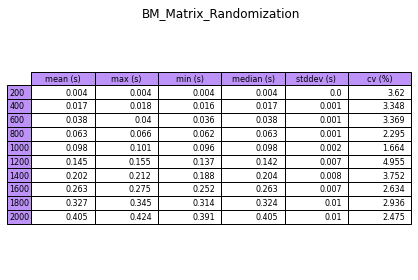

In [13]:
draw_table(parse_bench_dict(parse_bench_json("./dist/benchmarks_randomization.json")), "BM_Matrix_Randomization")

##### Transposição

Os tempos de transposição de cada tamanho de matriz são mostrados a seguir:

In [ ]:
!./dist/bin/matrix_cache_benchmarks \
  --benchmark_repetitions=10\
  --benchmark_report_aggregates_only=true\
  --benchmark_display_aggregates_only=true\
  --benchmark_out_format=json\
  --benchmark_out=dist/benchmarks_transposition.json\
  --benchmark_filter="BM_Matrix_Transposition"

O gráfico mostrando a **média**, **mediana**, **desvio padrão**, **máximo** e **mínimo** de tempo de randomização em função do tamanho da matriz pode ser visto a seguir:

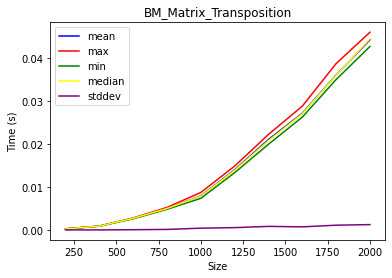

In [14]:
plot_all_aggregations(parse_bench_dict(parse_bench_json("./dist/benchmarks_transposition.json")), "BM_Matrix_Transposition")


Os mesmos dados organizados em uma tabela por tamanho da matriz:

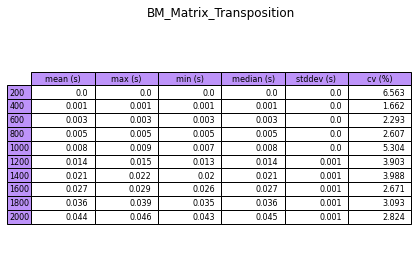

In [15]:
draw_table(parse_bench_dict(parse_bench_json("./dist/benchmarks_transposition.json")), "BM_Matrix_Transposition")

##### Multiplicação

###### Normal

Os tempos de multiplicação de cada tamanho de matriz são mostrados a seguir:

In [ ]:
!./dist/bin/matrix_cache_benchmarks \
  --benchmark_repetitions=10\
  --benchmark_report_aggregates_only=true\
  --benchmark_display_aggregates_only=true\
  --benchmark_out_format=json\
  --benchmark_out=dist/benchmarks_multiplication.json\
  --benchmark_filter="BM_Matrix_Multiplication/"

O gráfico mostrando a **média**, **mediana**, **desvio padrão**, **máximo** e **mínimo** de tempo de multiplicação normal em função do tamanho da matriz pode ser visto a seguir:

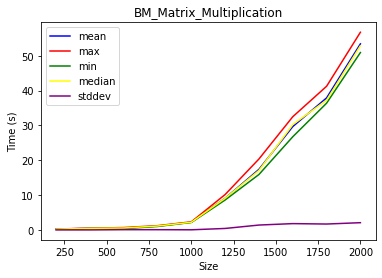

In [16]:
plot_all_aggregations(parse_bench_dict(parse_bench_json("./dist/benchmarks_multiplication.json")), "BM_Matrix_Multiplication")


Os mesmos dados organizados em uma tabela por tamanho da matriz:

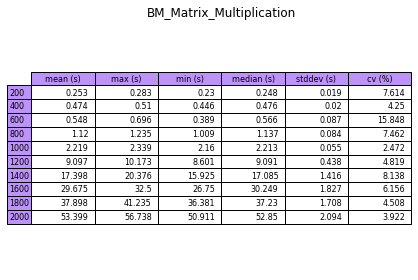

In [17]:
draw_table(parse_bench_dict(parse_bench_json("./dist/benchmarks_multiplication.json")), "BM_Matrix_Multiplication")

###### Transposta

Os tempos de multiplicação transposta de cada tamanho de matriz são mostrados a seguir:

In [ ]:
!./dist/bin/matrix_cache_benchmarks \
  --benchmark_repetitions=10\
  --benchmark_report_aggregates_only=true\
  --benchmark_display_aggregates_only=true\
  --benchmark_out_format=json\
  --benchmark_out=dist/benchmarks_multiplication_transposed.json\
  --benchmark_filter="BM_Matrix_Multiplication_transposed/"

O gráfico mostrando a **média**, **mediana**, **desvio padrão**, **máximo** e **mínimo** de tempo de multiplicação transposta em função do tamanho da matriz pode ser visto a seguir:

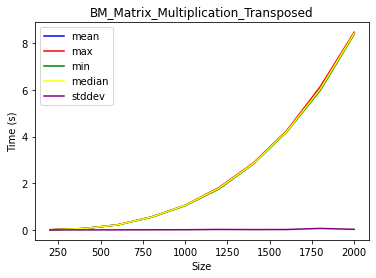

In [18]:
plot_all_aggregations(parse_bench_dict(parse_bench_json("./dist/benchmarks_multiplication_transposed.json")), "BM_Matrix_Multiplication_Transposed")


Os mesmos dados organizados em uma tabela por tamanho da matriz:

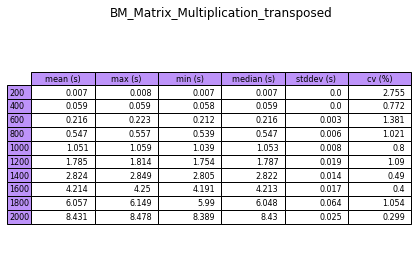

In [19]:
draw_table(parse_bench_dict(parse_bench_json("./dist/benchmarks_multiplication_transposed.json")), "BM_Matrix_Multiplication_transposed")

#### Memória Cache

Como discutido anteriormente, a ferramenta _valgrind_ será usada para o benchmark de uso de memória cache das multiplicações. Para ambos os algoritmos, normal e tranposto, será utilizado matrizes quadradas de dimensões $m=n=350$. 

##### Normal

In [12]:
!valgrind --tool=cachegrind ./dist/bin/matrix_cache_run -m 350,350 -m 350,350

==45977== Cachegrind, a cache and branch-prediction profiler
==45977== Copyright (C) 2002-2017, and GNU GPL'd, by Nicholas Nethercote et al.
==45977== Using Valgrind-3.19.0 and LibVEX; rerun with -h for copyright info
==45977== Command: ./dist/bin/matrix_cache_run -m 350,350 -m 350,350
==45977== 
--45977-- warning: L3 cache found, using its data for the LL simulation.
==45977== 
==45977== I   refs:      1,327,919,198
==45977== I1  misses:            9,477
==45977== LLi misses:            5,181
==45977== I1  miss rate:          0.00%
==45977== LLi miss rate:          0.00%
==45977== 
==45977== D   refs:      1,128,883,330  (1,006,092,643 rd   + 122,790,687 wr)
==45977== D1  misses:       45,853,904  (   45,756,298 rd   +      97,606 wr)
==45977== LLd misses:           74,027  (        9,941 rd   +      64,086 wr)
==45977== D1  miss rate:           4.1% (          4.5%     +         0.1%  )
==45977== LLd miss rate:           0.0% (          0.0%     +         0.1%  )
==45977== 
==45977==

##### Transposto

In [13]:
!valgrind --tool=cachegrind ./dist/bin/matrix_cache_run -m 350,350 -m 350,350 -t

==48285== Cachegrind, a cache and branch-prediction profiler
==48285== Copyright (C) 2002-2017, and GNU GPL'd, by Nicholas Nethercote et al.
==48285== Using Valgrind-3.19.0 and LibVEX; rerun with -h for copyright info
==48285== Command: ./dist/bin/matrix_cache_run -m 350,350 -m 350,350 -t
==48285== 
--48285-- warning: L3 cache found, using its data for the LL simulation.
==48285== 
==48285== I   refs:      1,331,775,991
==48285== I1  misses:            9,754
==48285== LLi misses:            5,292
==48285== I1  miss rate:          0.00%
==48285== LLi miss rate:          0.00%
==48285== 
==48285== D   refs:      1,131,907,093  (1,008,598,494 rd   + 123,308,599 wr)
==48285== D1  misses:        5,730,801  (    5,494,864 rd   +     235,937 wr)
==48285== LLd misses:           90,092  (       10,517 rd   +      79,575 wr)
==48285== D1  miss rate:           0.5% (          0.5%     +         0.2%  )
==48285== LLd miss rate:           0.0% (          0.0%     +         0.1%  )
==48285== 
==4828

## Comparações e considerações finais

### Tempo

Ficou claro que a multiplicação com o método transposto obteve tempos de execução muito melhores em relação a multiplicação comum:

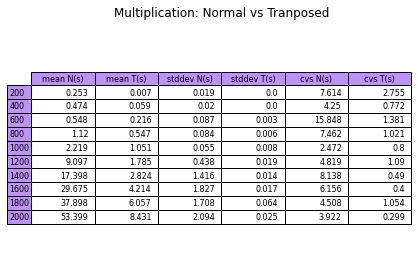

In [14]:
draw_table_comparsion(parse_bench_dict(parse_bench_json("./dist/benchmarks_multiplication.json")), parse_bench_dict(parse_bench_json("./dist/benchmarks_multiplication_transposed.json")), "Multiplication: Normal vs Tranposed")

Observando o gráfico de comparação das médias dos dois métodos, fica claro que **a medida que o número de elementos aumenta, o tempo de execução do método transposto tende a aumentar menos que o do método normal:**

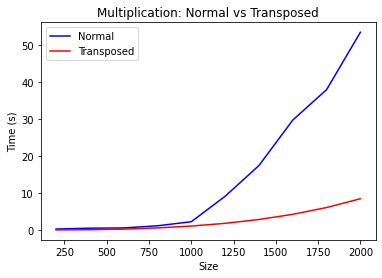

In [16]:
plot_comparsion(parse_bench_dict(parse_bench_json("./dist/benchmarks_multiplication.json")), parse_bench_dict(parse_bench_json("./dist/benchmarks_multiplication_transposed.json")), "Multiplication: Normal vs Transposed", "mean")

Outra coisa que ficou facilmente perceptível é que, **a medida que o tamanho das matrizes aumentou, o desvio padrão das execuções em cada tamanho aumentou muito menos no método transposto do que no método normal**. Também vemos isso no **coeficiente de variação** pra cada tamanho de matriz, que sempre foi muito menor no método transposto.

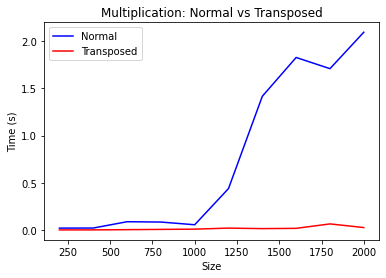

In [17]:
plot_comparsion(parse_bench_dict(parse_bench_json("./dist/benchmarks_multiplication.json")), parse_bench_dict(parse_bench_json("./dist/benchmarks_multiplication_transposed.json")), "Multiplication: Normal vs Transposed", "stddev")

#### speedup

O _speedup_ é uma métrica de tempo utilizada para representar a porcentagem de melhora que a modificação de um algoritmo teve em relação a implementação base. Dado o tempo de execução base $t_{old}$ e o novo tempo de execução $t_{new}$, o speedup é definido como:

$speedup = \frac{t_{new}}{t_{old}}$

Os valores de speedup para cada tamanho de matriz:

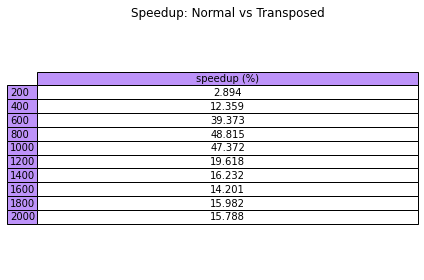

In [20]:
draw_speedup_table(parse_bench_dict(parse_bench_json("./dist/benchmarks_multiplication.json")), parse_bench_dict(parse_bench_json("./dist/benchmarks_multiplication_transposed.json")), "Speedup: Normal vs Transposed")

O gráfico com os valores de speedup por tamanho de matriz pode ser visto a seguir:

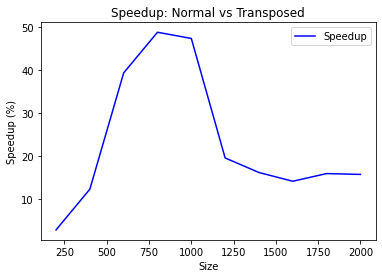

In [21]:
plot_speedup(parse_bench_dict(parse_bench_json("./dist/benchmarks_multiplication.json")), parse_bench_dict(parse_bench_json("./dist/benchmarks_multiplication_transposed.json")), "Speedup: Normal vs Transposed")

Nota-se que o valor de speedup cresceu até matrizes de tamanho 800x800, após isso, os valores de speedup diminuíram.

### Memória Cache

Notou-se que o valor de _cache miss rate_ foi menor no método transposto, $0.5\%$, em comparação com $4.1\%$ no método Normal. 

Utilizando a flag de compilação _-O3_, foi obtido resultados muito melhores de _cache miss rate_, porém houve uma discrepância no número de instruções dos métodos, com o método transposto tendo menos instruções do que o método normal.  